In [1]:
pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.0/30.0 MB 34.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


T* = 0.7877024107695236


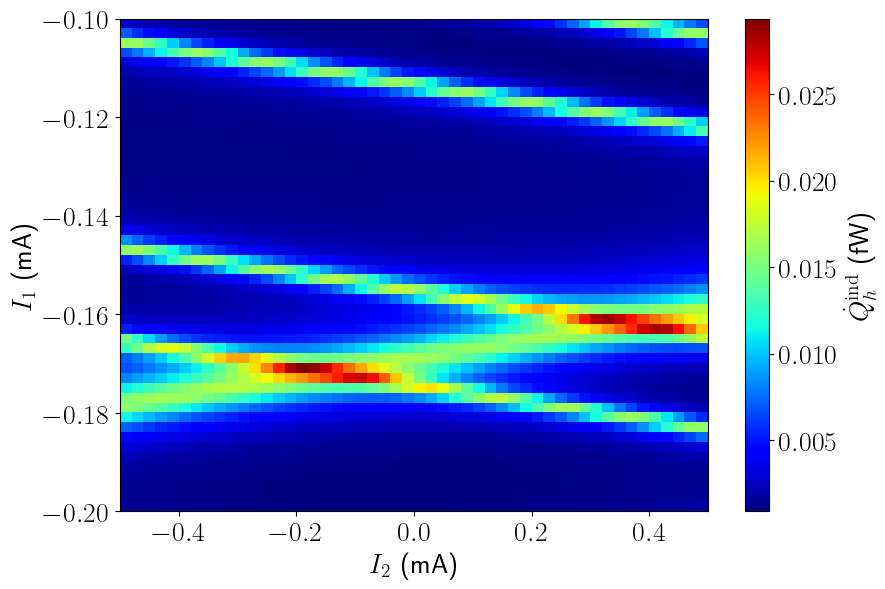

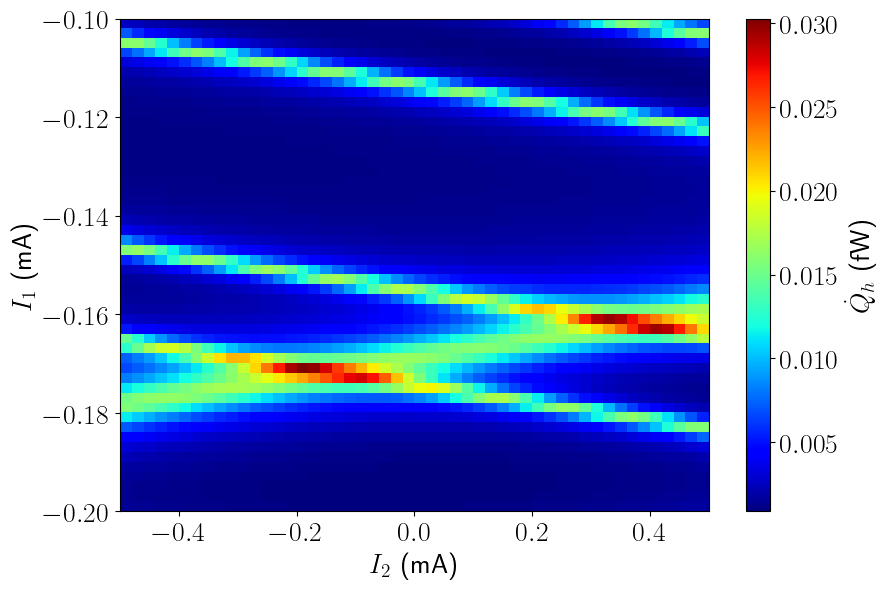

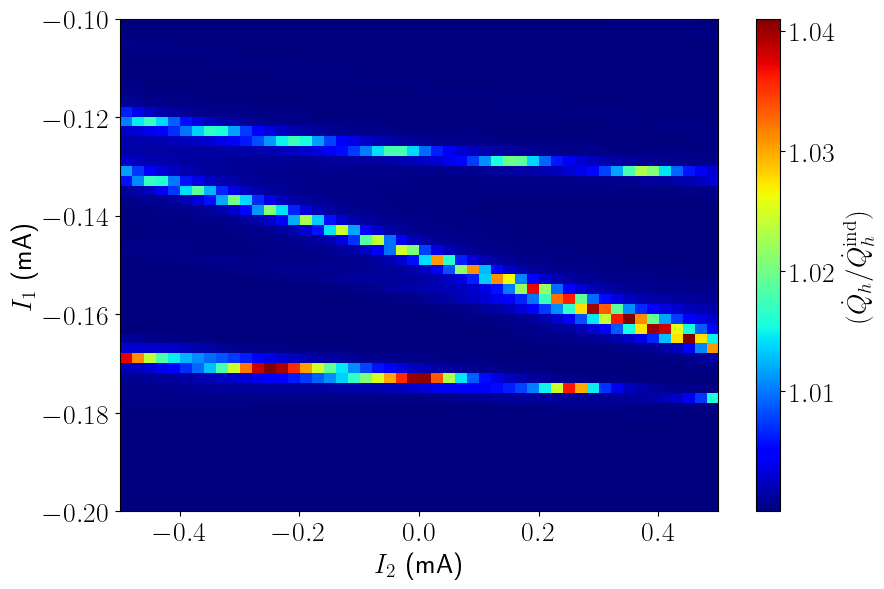

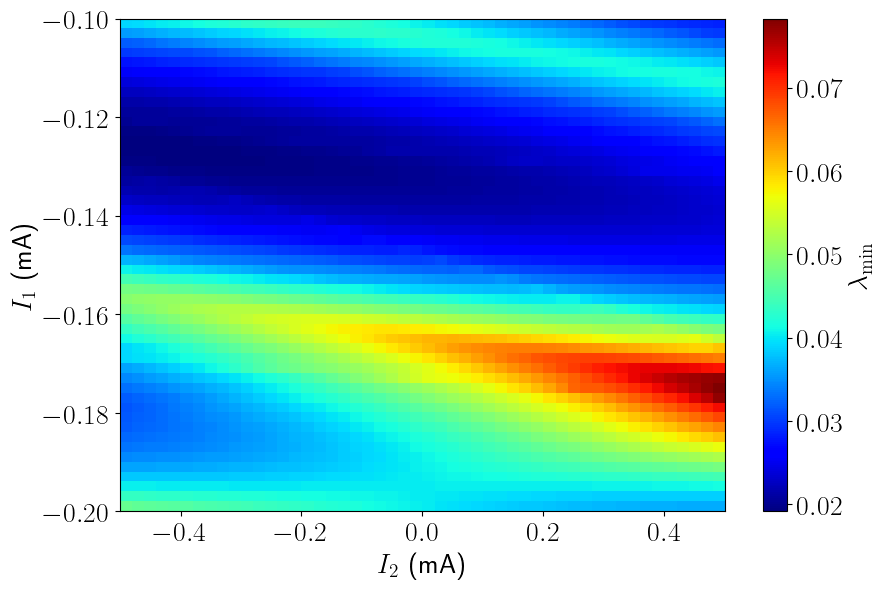

In [5]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Two qubit heat valve core routines
----------------------------------
This module gathers the Hamiltonian, bath spectra, steady state solvers,
and heat current estimators required for a two qubit heat valve model.
The numerical engine combines a Bloch–Redfield kernel for the collective
resonator bath with local Lindblad channels that emulate parasitic
relaxation and pure dephasing.  All comments describe the physical
purpose of each line without altering the underlying logic.
"""

import os  # Only needed if figures or data are saved elsewhere
import numpy as np
import matplotlib.pyplot as plt
from qutip import (
    tensor, basis, qeye,
    sigmax, sigmay, sigmaz, sigmam, sigmap,
    bloch_redfield_tensor, liouvillian, steadystate, expect,
    operator_to_vector,   # |ρ⟩⟩ mapping (unused here but imported for completeness)
    vector_to_operator
)
from matplotlib import rc  # Global LaTeX rendering control

# -----------------------------------------------------------------------------
#                              Numerical constants
# -----------------------------------------------------------------------------
# Regularisation threshold: whenever |ω| ≤ ε the Bose factor is set to zero to
# avoid a logarithmic divergence.

epsilon = 1e-13

# -----------------------------------------------------------------------------
#                    Two qubit operator algebra (tensor basis)
# -----------------------------------------------------------------------------
# Single qubit Pauli operators embedded in the full four level Hilbert space.
# Example: σ_x^{(1)} ≡ σ_x ⊗ 𝟙, σ_x^{(2)} ≡ 𝟙 ⊗ σ_x.

sx1, sy1, sz1 = (tensor(op, qeye(2)) for op in (sigmax(), sigmay(), sigmaz()))
sx2, sy2, sz2 = (tensor(qeye(2), op) for op in (sigmax(), sigmay(), sigmaz()))
sm1 = tensor(sigmam(), qeye(2)); sp1 = tensor(sigmap(), qeye(2))
sm2 = tensor(qeye(2), sigmam()); sp2 = tensor(qeye(2), sigmap())

# Collective raising/lowering operators: J_± = σ_±^{(1)} + σ_±^{(2)}.
Jm = sm1 + sm2
Jp = sp1 + sp2

# -----------------------------------------------------------------------------
#                    Thermal occupation and effective temperature
# -----------------------------------------------------------------------------

def nB(omega: float, T: float) -> float:
    """Bose–Einstein occupation n_B(ω, T) with overflow protection."""
    if abs(omega) <= epsilon:
        return 0.0
    beta = 1.0 / T
    if beta * abs(omega) > 700:  # exp(700) is close to float overflow
        return 0.0
    return 1.0 / (np.exp(beta * omega) - 1.0)


def T_star(T_c: float, gamma_c: float, T_h: float, gamma_h: float, w0: float) -> float:
    """Effective temperature of the composite resonator bath."""
    den = (
        (nB(w0, T_h) + 1) * gamma_h + (nB(w0, T_c) + 1) * gamma_c
    ) / (
        nB(w0, T_h) * gamma_h + nB(w0, T_c) * gamma_c
    )
    return w0 / np.log(den)

# -----------------------------------------------------------------------------
#                       Bath spectral densities (Lorentzian)
# -----------------------------------------------------------------------------
# Each bath spectrum J(ω) is formed by a Bose factor times a Lorentzian filter
# centred at the resonator frequency w0 with quality factor Q1.


def J_h(w: float, T_h: float, gamma_h: float, w0: float, Q1: float) -> float:
    """Hot bath spectrum J_h(ω)."""
    w_abs = np.abs(w)
    nb = nB(w_abs, T_h)
    lam = w0 / Q1  # Full width at half maximum Γ = ω0 / Q
    Lor = (0.5 * lam) / ((w_abs - w0) ** 2 + (0.5 * lam) ** 2)
    return (
        gamma_h * (1.0 + nb) * (w > epsilon) +
        gamma_h * nb * (w < -epsilon)
    ) * Lor


def J_c(w: float, T_c: float, gamma_c: float, w0: float, Q1: float) -> float:
    """Cold bath spectrum J_c(ω)."""
    w_abs = np.abs(w)
    nb = nB(w_abs, T_c)
    lam = w0 / Q1
    Lor = (0.5 * lam) / ((w_abs - w0) ** 2 + (0.5 * lam) ** 2)
    return (
        gamma_c * (1.0 + nb) * (w > epsilon) +
        gamma_c * nb * (w < -epsilon)
    ) * Lor


def J_global(w: float, T_c: float, gamma_c: float, T_h: float, gamma_h: float,
             w0: float, Q1: float) -> float:
    """Composite spectrum J_global(ω) = J_c + J_h."""
    return J_c(w, T_c, gamma_c, w0, Q1) + J_h(w, T_h, gamma_h, w0, Q1)

# -----------------------------------------------------------------------------
#                            Heat current estimators
# -----------------------------------------------------------------------------
# *Current_ind* computes the heat current into the hot bath when each qubit
# couples independently.  *Current_coll* does the same for collective coupling.


def Current_ind(w1: float, w2: float, rho, T_h: float, gamma_h: float,
                w0: float, Q1: float) -> float:
    """Independent coupling heat current for a given steady state ρ."""
    # Transition rates for each qubit
    rate_sm1 = J_h(+w1, T_h, gamma_h, w0, Q1)
    rate_sp1 = J_h(-w1, T_h, gamma_h, w0, Q1)
    rate_sm2 = J_h(+w2, T_h, gamma_h, w0, Q1)
    rate_sp2 = J_h(-w2, T_h, gamma_h, w0, Q1)
    # Two point correlators ⟨σ_± σ_∓⟩
    Sp1Sm1 = expect(sp1 * sm1, rho)
    Sm1Sp1 = expect(sm1 * sp1, rho)
    Sp2Sm2 = expect(sp2 * sm2, rho)
    Sm2Sp2 = expect(sm2 * sp2, rho)
    # Energy balance
    Q_dot  = w1 * (-rate_sm1 * Sp1Sm1 + rate_sp1 * Sm1Sp1)
    Q_dot += w2 * (-rate_sm2 * Sp2Sm2 + rate_sp2 * Sm2Sp2)
    return Q_dot


def Current_coll(w1: float, w2: float, rho, T_h: float, gamma_h: float,
                 w0: float, Q1: float) -> float:
    """Collective coupling heat current for a given steady state ρ."""
    Q_dot = 0.0
    if w1 == w2:  # Degenerate qubits ⇒ collective J_± jumps only
        En = np.array([w1, -w1])
        S = [Jm, Jp]
        for i in range(2):
            for j in range(2):
                Q_dot += -J_h(+En[i], T_h, gamma_h, w0, Q1) * En[j] * \
                         expect((S[i].dag() * S[j] + S[j].dag() * S[i]), rho) / 2
    else:  # Non degenerate case: revert to individual σ_± operators
        En = np.array([w1, w2, -w1, -w2])
        S = [sm1, sm2, sp1, sp2]
        for i in range(4):
            for j in range(4):
                Q_dot += -J_h(+En[i], T_h, gamma_h, w0, Q1) * En[j] * \
                         expect((S[i].dag() * S[j] + S[j].dag() * S[i]), rho) / 2
    return Q_dot

# -----------------------------------------------------------------------------
#                  Steady state solvers (collective vs independent)
# -----------------------------------------------------------------------------


def rho_ss_termic_collective(w1: float, w2: float, gamma_local: float,
                             T_local: float, gamma_deph: float,
                             T_h: float, gamma_h: float,
                             T_c: float, gamma_c: float,
                             w0: float, Q1: float):
    """Steady state with collective resonator coupling."""
    # System Hamiltonian H = ½(ω1 σ_z^{(1)} + ω2 σ_z^{(2)})
    H = 0.5 * (w1 * sz1 + w2 * sz2)
    # Collective system operator that couples to the resonator mode
    sigma_sum = sx1 + sx2
    a_ops_coll = [[sigma_sum,
                   lambda w: J_global(w, T_c, gamma_c, T_h, gamma_h, w0, Q1)]]
    R = bloch_redfield_tensor(H, a_ops_coll, fock_basis=True, sec_cutoff=-1)
    # Local Lindblad channels: thermal relaxation plus pure dephasing
    c_ops = [
        np.sqrt(gamma_local * (1 + nB(w1, T_local))) * sm1,
        np.sqrt(gamma_local * nB(w1, T_local))       * sp1,
        np.sqrt(gamma_local * (1 + nB(w2, T_local))) * sm2,
        np.sqrt(gamma_local * nB(w2, T_local))       * sp2,
        np.sqrt(gamma_deph) * sz1,
        np.sqrt(gamma_deph) * sz2,
    ]
    L_full = R + liouvillian(0 * sz1, c_ops)  # No additional Hamiltonian term
    return steadystate(L_full, method='direct')


def rho_ss_termic_indepentend(
    w1, w2,
    gamma_local, T_local, gamma_deph,
    T_h, gamma_h, T_c, gamma_c,
    w0, Q1
):
    """
    Steady state for the *independent-bath* configuration.

    Each qubit feels the composite resonator spectrum J_global(ω) **locally**
    (i.e. as its own Lindblad channel).  In addition, both qubits couple to a
    parasitic thermal bath at T_local and to a pure-dephasing bath with rate
    gamma_deph.
    """
    # Resonator-induced relaxation / absorption rates
    rate_sm1 = J_global(+w1, T_c, gamma_c, T_h, gamma_h, w0, Q1)
    rate_sp1 = J_global(-w1, T_c, gamma_c, T_h, gamma_h, w0, Q1)
    rate_sm2 = J_global(+w2, T_c, gamma_c, T_h, gamma_h, w0, Q1)
    rate_sp2 = J_global(-w2, T_c, gamma_c, T_h, gamma_h, w0, Q1)

    # Full list of collapse operators:
    #   ─ resonator (first four),
    #   ─ parasitic thermalisation (next four),
    #   ─ pure dephasing (last two).
    c_global_local = [
        np.sqrt(rate_sm1) * sm1,
        np.sqrt(rate_sp1) * sp1,
        np.sqrt(rate_sm2) * sm2,
        np.sqrt(rate_sp2) * sp2,
        np.sqrt(gamma_local * (1 + nB(w1, T_local))) * sm1,
        np.sqrt(gamma_local * nB(w1, T_local))       * sp1,
        np.sqrt(gamma_local * (1 + nB(w2, T_local))) * sm2,
        np.sqrt(gamma_local * nB(w2, T_local))       * sp2,
        np.sqrt(gamma_deph) * sz1,
        np.sqrt(gamma_deph) * sz2,
    ]

    # Bare Hamiltonian: non-interacting qubits with splittings w1, w2.
    H = 0.5 * (w1 * sz1 + w2 * sz2)

    # Liouvillian and steady state.
    L_full = liouvillian(H, c_global_local)
    rho_ss = steadystate(L_full, method="direct")
    return rho_ss


# -------------------------------------------------------------------
# Minimal physical parameters for a N×N frequency sweep
# -------------------------------------------------------------------
w0 = 1          # LC resonator frequency (sets the unit scale)
Qf = 7.1798        # Resonator quality factor

# Bath coupling strengths
gamma_h   = 0.0075   # Hot bath, calculated using Eq.(B19) from the superradiance enhancement paper
gamma_c   = 0.0075  # Cold bath, assumed to be equal to the hot bath
gamma_local = 0.001 #0.001   # Parasitic relaxation
gamma_deph  = 0.001  # Pure dephasing (σ_z)

# Temperatures  (ℏ = k_B = 1)
T_local = 0.186    # Parasitic bath
T_h     = 1.2087    # Hot bath
T_c     = 0.186   # Cold bath
N=50

# Diagnostic: effective temperature of the composite resonator bath
Ts = T_star(T_c, gamma_c, T_h, gamma_h, w0)
print("T* =", Ts)

# Introduction of Mutual Inductance

M = np.array([[16.0824, 0.2855], 
              [6.1438, -0.1156]]) # Experimentally calculated mutual inductance matrix
#M = np.array([[16.2956, 0.1996], 
              #[-6.4449, 0.1337]])

I_1_values = np.linspace(-0.2, -0.1, N); # Instead of a frequency sweep, we are doing a current sweep
I_2_values = np.linspace(-0.5, 0.5, N);

O = np.array([[-2.5284/3], 
             [-0.8872/3]]) # Experimentally calculated offset 
#O = np.array([[1.0079], 
             # [0.3949]])
h = 1
d = 0.17 # junction asymmetry parameter
f_r = 5.6e9 # Resonator frequency for normalization
#E_j0 = (36.852426499562085e9 * h)
E_j0_1 = (55.748e9/f_r)*h #54.944e9*h #30.56638e9 * h # Experimentally verified maximum josephson energy for qubit 1
E_j0_2 = (53.725e9/f_r)*h #49.037818e9*h #30.0162e9 * h # Experimentally verified maximum josephson energy for qubit 1
E_c = (150e6/f_r) * h # Experimentally verified charging energy for qubit 1

phi_0 = 2.067e-15
f_q1_values = np.zeros(N)
f_q2_values = np.zeros(N)
phi_q1_values = np.zeros(N)
phi_q2_values = np.zeros(N)
E_j1_values = np.zeros(N)
E_j2_values = np.zeros(N)
W1, W2 = np.meshgrid(I_1_values, I_2_values)

Q_ind   = np.zeros_like(W1)   # independent current
Q_coll  = np.zeros_like(W1)   # collective current
Ratio   = np.zeros_like(W1)   # enhancement factor
Lambda  = np.zeros_like(W1)   # minimum eigenvalue (positivity check)
Rho_ind = np.zeros_like(W1)   
Rho_coll = np.zeros_like(W1)  # To store and plot density matrix element corresponding to coherence
for i, I1 in enumerate(I_1_values):
    for j, I2 in enumerate(I_2_values):
        I_vec = np.array([[I1], [I2]])
        phi_q = (M @ I_vec)*phi_0 + (O * phi_0) # (phi_q1, phi_q2) = M*I*phi_0 + O*phi_0
        phi_q1, phi_q2 = phi_q  
        
        
        phi_q1_values[i] = phi_q1
        phi_q2_values[i] = phi_q2
        E_j_q1 = E_j0_1 * abs(np.cos((np.pi * phi_q1) / phi_0)) * np.sqrt(1 + d**2 * (np.tan((np.pi * phi_q1) / phi_0))**2) # Qubit 1 josephson energy
        E_j_q2 = E_j0_2 * abs(np.cos((np.pi * phi_q2) / phi_0)) * np.sqrt(1 + d**2 * (np.tan((np.pi * phi_q2) / phi_0))**2) # Qubit 2 josephson energy
        E_j1_values[i] = E_j_q1
        
        f_q1 = (np.sqrt(8 * E_j_q1 * E_c) - E_c) / (h) # Qubit 1 frequency
       
        f_q1_values[i] = f_q1
        f_q2 = (np.sqrt(8 * E_j_q2 * E_c) - E_c) / (h) # Qubit 2 frequency
        f_q2_values[i] = f_q2
        
        # Independent-bath steady state and current
        rho_ind = rho_ss_termic_indepentend(
            f_q1, f_q2,
            gamma_local, T_local, gamma_deph,
            T_h, gamma_h, T_c, gamma_c,
            w0, Qf
        )
        Rho_ind[j, i] = np.real(rho_ind[1][1])
        Q_ind[j, i] = Current_ind(f_q1, f_q2, rho_ind, T_h, gamma_h, w0, Qf)

        # Collective-bath steady state and current
        rho_coll = rho_ss_termic_collective(
            f_q1, f_q2,
            gamma_local, T_local, gamma_deph,
            T_h, gamma_h, T_c, gamma_c,
            w0, Qf
        )
        Rho_coll[j, i] = np.real(rho_coll[1][2]) # Storing the coherent term in the density matrix
        Q_coll[j, i] = Current_coll(f_q1, f_q2, rho_coll, T_h, gamma_h, w0, Qf)

        # Diagnostics
        Lambda[j, i] = np.min(np.linalg.eigvalsh(rho_coll.full()))
        Ratio[j, i]  = Q_coll[j, i] / Q_ind[j, i]
            




# -------------------------------------------------------------------
# Frequency grid and heat-current maps
# -------------------------------------------------------------------
#w_vals = np.linspace(0.5, 1.5, N)



#print("The collective density matrix is =", rho_coll)
#print("The independent density matrix is =", rho_ind)

# Plot colormap
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    0.662607015*Q_ind.T, 
    extent=(I_2_values.min(), I_2_values.max(), I_1_values.min(), I_1_values.max()),
    aspect='auto',
    origin='lower', cmap = 'jet'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$I_2$ (mA)', fontsize=20)
plt.ylabel(r'$I_1$ (mA)', fontsize=20)

cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\dot Q^{\rm ind}_h$ (fW)', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()


os.makedirs('Figs', exist_ok=True)
plt.savefig('Figs/HeatCurrent_ind.pdf', dpi=300)
################################################################################################################################################

plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    0.662607015*Q_coll.T,  # negative heat current for display
    extent=(I_2_values.min(), I_2_values.max(), I_1_values.min(), I_1_values.max()),
    aspect='auto',
    origin='lower', cmap = 'jet'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$I_2$ (mA)', fontsize=20)
plt.ylabel(r'$I_1$ (mA)', fontsize=20)

cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\dot Q_h$ (fW)', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()




os.makedirs('Figs', exist_ok=True)
plt.savefig('Figs/HeatCurrent_coll.pdf', dpi=300)
###############################################################################################################################################





plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Ratio.T,  
    extent=(I_2_values.min(), I_2_values.max(), I_1_values.min(), I_1_values.max()),
    aspect='auto',
    origin='lower', cmap = 'jet'
)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel(r'$I_2$ (mA)', fontsize=20)
plt.ylabel(r'$I_1$ (mA)', fontsize=20)



# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$(\dot Q_h/\dot Q_h^{\rm ind})$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()




os.makedirs('Figs', exist_ok=True)
plt.savefig('Figs/HeatCurrent_ratio.pdf', dpi=300)





plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Lambda.T,  # negative heat current for display
    extent=(I_2_values.min(), I_2_values.max(), I_1_values.min(), I_1_values.max()),
    aspect='auto',
    origin='lower', cmap = 'jet'
)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel(r'$I_2$ (mA)', fontsize=20)
plt.ylabel(r'$I_1$ (mA)', fontsize=20)



# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\lambda_{\rm min}$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()




os.makedirs('Figs', exist_ok=True)
plt.savefig('Figs/min_val_rho.pdf', dpi=300)


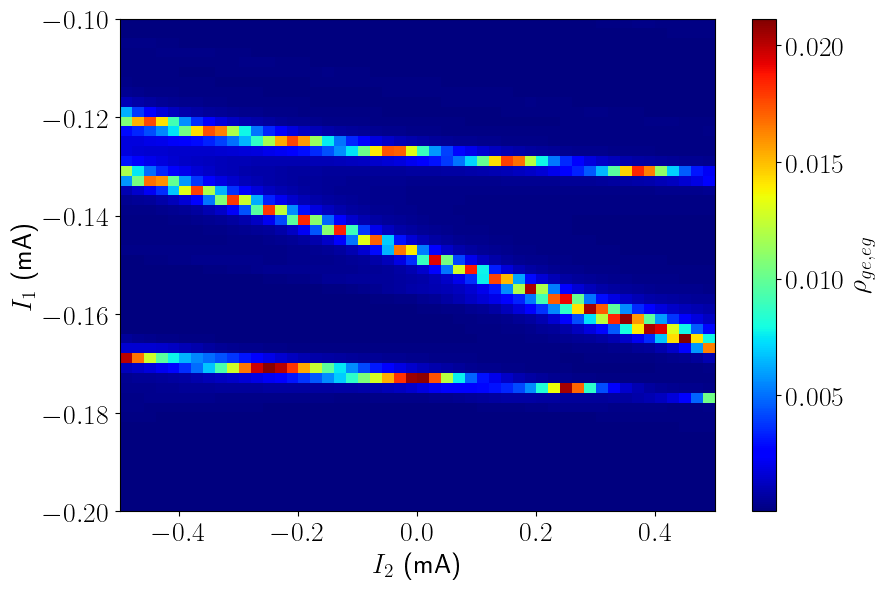

In [6]:
# Plotting one of the coherence terms in the density matrix
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Rho_coll.T,  
    extent=(I_2_values.min(), I_2_values.max(), I_1_values.min(), I_1_values.max()),
    aspect='auto',
    origin='lower', cmap = 'jet'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$I_2$ (mA)', fontsize=20)
plt.ylabel(r'$I_1$ (mA)', fontsize=20)

cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\rho_{ge, eg}$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()

In [8]:
#Plotting the dependence of enhancement on the ratio between gamma_deph/gamma_local, while fixing gamma_deph

w0 = 1          # LC resonator frequency (sets the unit scale)
Qf = 7.1798        # Resonator quality factor
N2 = 1000

# Bath coupling strengths
gamma_h   = 0.0075   # Hot bath
gamma_c   = 0.0075   # Cold bath
gamma_local = np.linspace(0.0001, 0.0075, N2) #0.001   # Parasitic relaxation
gamma_deph  = 0.0075  # Pure dephasing (σ_z)

# Temperatures  (ℏ = k_B = 1)
T_local = 0.186    # Parasitic bath
T_h     = 1.2087    # Hot bath
T_c     = 0.186   # Cold bath
N=50

# Diagnostic: effective temperature of the composite resonator bath
Ts = T_star(T_c, gamma_c, T_h, gamma_h, w0)
print("T* =", Ts)

#w_vals = np.linspace(0.5, 1.5, N)
#W1, W2 = np.meshgrid(w_vals, w_vals)

Q_ind_2   = np.zeros(N2)   # independent current
Q_coll_2  = np.zeros(N2)  # collective current
Ratio_2   = np.zeros(N2)   # enhancement factor
Lambda_2  = np.zeros(N2)   # minimum eigenvalue (positivity check)
Rho_ind_2 = np.zeros(N2)
Rho_coll_2 = np.zeros(N2)

for k, gamma_p in enumerate(gamma_local):

    # Independent-bath steady state and current
    rho_ind = rho_ss_termic_indepentend(
        1, 1,
        gamma_p, T_local, gamma_deph,
        T_h, gamma_h, T_c, gamma_c,
        w0, Qf
    )
    Rho_ind_2[k] = np.real(rho_ind[1][1])
    Q_ind_2[k] = Current_ind(1, 1, rho_ind, T_h, gamma_h, w0, Qf)

    # Collective-bath steady state and current
    rho_coll = rho_ss_termic_collective(
        1, 1,
        gamma_p, T_local, gamma_deph,
        T_h, gamma_h, T_c, gamma_c,
        w0, Qf
    )
    Rho_coll_2[k] = np.real(rho_coll[1][2])
    Q_coll_2[k] = Current_coll(1, 1, rho_coll, T_h, gamma_h, w0, Qf)

    # Diagnostics
    Lambda_2[k] = np.min(np.linalg.eigvalsh(rho_coll.full()))
    Ratio_2[k]  = Q_coll_2[k] / Q_ind_2[k]


T* = 0.7877024107695236


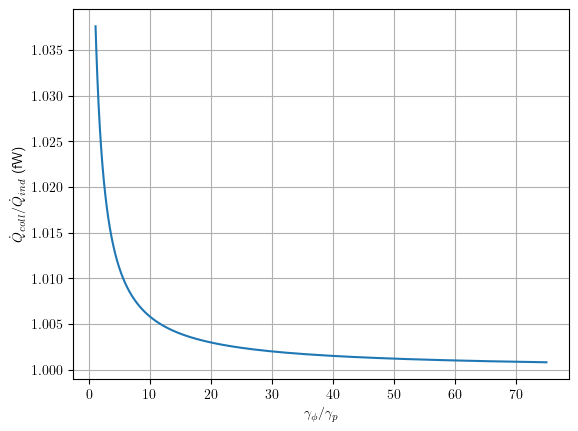

In [9]:
plt.plot(gamma_deph/gamma_local, Q_coll_2/Q_ind_2)
plt.xlabel(r'$\gamma_{\phi}/\gamma_p$')
plt.ylabel(r'$\dot{Q}_{coll}/\dot{Q}_{ind}$ (fW)')
#plt.legend()
plt.grid(True)
plt.show()